In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore") 

In [2]:
#Loading the dataset
df = pd.read_csv("wine.csv")

In [3]:
df.isnull().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<AxesSubplot:>

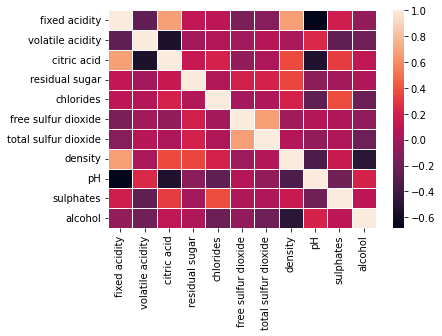

In [6]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=.5)

In [7]:
label_encoder =LabelEncoder()
df['quality']= label_encoder.fit_transform(df['quality'])
print(label_encoder.inverse_transform((0,1)))


['bad' 'good']


In [8]:
n=10
fold_value = (len(df)+1)//n

In [9]:
def evaluation_metrics(tp,tn,fp,fn):
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    precision = tp / (tp+fp)
    recall= tp / (tp+fn)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(tn+fp)
    fp_rate = fp/(tn+fp)
    fn_rate = fn/(tp+fn)
    f1_measure = 2*(precision*recall)/(precision+recall)
    error_rate = (fp+fn)/(tp+tn+fp+fn)
    balance_accuracy = (tp_rate + tn_rate)/2
    TSS = (tp/(tp+fn))-(fp/(fp+tn))
    HSS = (2*((tp*tn)-(fp*fn)))/((tp+fn)*(fn+tn)+(fp+tp)*(fp+tn))
    return tp_rate,tn_rate,fp_rate,fn_rate,accuracy,precision,recall,f1_measure,error_rate,balance_accuracy,TSS,HSS
          
def confusion_matrix(truth,predicted):
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for true,pred in zip(truth,predicted):
        if true == 1:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    positive = true_positive + false_negative
    negative = true_negative + false_positive
    
    confusion_matrix_res = [[true_negative, false_negative],[false_positive,true_positive]]
    
    return true_positive,true_negative,false_positive,false_negative,confusion_matrix_res

In [10]:
colnames=["fold","model","Confusion matrix","TruePositive rate","True Negative rate","False positive rate","False Negative rate","Accuracy","Precision","Recall","F1 measure","Error rate","Balance Accuracy","TSS","HSS"]
result = pd.DataFrame(columns=colnames)

copy_df=df

accuracy = 0.0
precision = 0.0
recall= 0.0
tp_rate = 0.0
tn_rate = 0.0
fp_rate = 0.0
fn_rate = 0.0
f1_measure = 0.0
error_rate = 0.0
balance_accuracy = 0.0
TSS = 0.0
HSS = 0.0
begin=0
end=0

for i in range( 1, n+1):
    end=begin+fold_value
    
    train =copy_df.drop(copy_df.index[begin:end])
    test = copy_df[begin:end]
    
    X_train = train.iloc[:,:-1]
    y_train = train.iloc[:,-1]
    
    X_test =  test.iloc[:,:-1]
    y_test = test.iloc[:,-1]
    
     
    modelknn = KNeighborsClassifier(n_neighbors=2)
    modelknn.fit(X_train,y_train)
    predknn = modelknn.predict(X_test)
    tp,tn,fp,fn,matrix=confusion_matrix(y_test,predknn)
    tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS  = evaluation_metrics(tp,tn,fp,fn)
    data = [i,"KNN",matrix,tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS]
    result.loc[len(result)] = data
    
    modelrf = RandomForestClassifier()
    modelrf.fit(X_train,y_train)
    predrf = modelrf.predict(X_test)
    tp,tn,fp,fn,matrix=confusion_matrix(y_test,predrf)
    tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS  = evaluation_metrics(tp,tn,fp,fn)
    data = [i,"RF",matrix,tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS]
    result.loc[len(result)] = data

    
    lst = Sequential()
    lst.add(LSTM(units=11, input_shape=(11,1)))
    lst.add(Dense(16,activation='tanh'))
    lst.add(Dense(1, activation='softmax'))
    lst.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    X_train=X_train.to_numpy()
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    lst.fit(X_train, y_train,epochs=5, batch_size=160)
    X_test=X_test.to_numpy()
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predlstm =lst.predict(X_test) 
    tp,tn,fp,fn,matrix=confusion_matrix(y_test,predlstm)
    tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS  = evaluation_metrics(tp,tn,fp,fn)
    data = [i,"LSTM",matrix,tp_rate,tn_rate,fp_rate ,fn_rate ,accuracy ,precision ,recall ,f1_measure ,error_rate ,balance_accuracy ,TSS ,HSS]
    result.loc[len(result)] = data
    result = result.append(pd.Series(), ignore_index=True)
    begin=end


Epoch 1/5
9/9 [==============================] - 1s 11ms/step - loss: 0.6802 - accuracy: 0.5615
Epoch 2/5
9/9 [==============================] - 0s 7ms/step - loss: 0.6783 - accuracy: 0.5615
Epoch 3/5
9/9 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.5615
Epoch 4/5
9/9 [==============================] - 0s 7ms/step - loss: 0.6738 - accuracy: 0.5615
Epoch 5/5
9/9 [==============================] - 0s 7ms/step - loss: 0.6724 - accuracy: 0.5615
Epoch 1/5
9/9 [==============================] - 1s 12ms/step - loss: 0.6852 - accuracy: 0.5400
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6815 - accuracy: 0.5400
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6800 - accuracy: 0.5400
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.5400
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.6743 - accuracy: 0.5400
Epoch 1/5
9/9 [==============================]

In [11]:
result.style.hide_index()

fold,model,Confusion matrix,TruePositive rate,True Negative rate,False positive rate,False Negative rate,Accuracy,Precision,Recall,F1 measure,Error rate,Balance Accuracy,TSS,HSS
1,KNN,"[[106, 33], [7, 14]]",0.297872,0.938053,0.061947,0.702128,0.750000,0.666667,0.297872,0.411765,0.250000,0.617963,0.235925,0.281383
1,RF,"[[95, 23], [18, 24]]",0.510638,0.840708,0.159292,0.489362,0.743750,0.571429,0.510638,0.539326,0.256250,0.675673,0.351346,0.362612
1,LSTM,"[[0, 0], [113, 47]]",1.000000,0.000000,1.000000,0.000000,0.293750,0.293750,1.000000,0.454106,0.706250,0.500000,0.000000,0.000000
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,KNN,"[[72, 53], [10, 25]]",0.320513,0.878049,0.121951,0.679487,0.606250,0.714286,0.320513,0.442478,0.393750,0.599281,0.198562,0.201268
2,RF,"[[65, 33], [17, 45]]",0.576923,0.792683,0.207317,0.423077,0.687500,0.725806,0.576923,0.642857,0.312500,0.684803,0.369606,0.371464
2,LSTM,"[[0, 0], [82, 78]]",1.000000,0.000000,1.000000,0.000000,0.487500,0.487500,1.000000,0.655462,0.512500,0.500000,0.000000,0.000000
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,KNN,"[[40, 59], [15, 46]]",0.438095,0.727273,0.272727,0.561905,0.537500,0.754098,0.438095,0.554217,0.462500,0.582684,0.165368,0.138909
3,RF,"[[37, 21], [18, 84]]",0.800000,0.672727,0.327273,0.200000,0.756250,0.823529,0.800000,0.811594,0.243750,0.736364,0.472727,0.466667


In [12]:
names = ["model","AVG TruePositive rate","AVG True Negative rate","AVG False positive rate","AVG False Negative rate","AVG Accuracy","AVG Precision","AVG Recall","AVG F1 measure","AVG Error rate","AVG Balance Accuracy","AVG TSS","AVG HSS"]
avg_df = pd.DataFrame(columns=names)
for i in ['KNN','RF','LSTM']:
    data = result.loc[result['model'] == i]
    avg=[i]
    for i in colnames[3:]:
        avg+=[data[i].mean()]
    avg_df.loc[len(avg_df)] = avg
avg_df

,model,AVG TruePositive rate,AVG True Negative rate,AVG False positive rate,AVG False Negative rate,AVG Accuracy,AVG Precision,AVG Recall,AVG F1 measure,AVG Error rate,AVG Balance Accuracy,AVG TSS,AVG HSS
0,KNN,0.412738,0.739939,0.260061,0.587262,0.584100,0.654932,0.412738,0.502121,0.415900,0.576339,0.152677,0.143827
1,RF,0.712011,0.696890,0.303110,0.287989,0.734807,0.731593,0.712011,0.717444,0.265193,0.704451,0.408901,0.413963
2,LSTM,1.000000,0.000000,1.000000,0.000000,0.534709,0.534709,1.000000,0.686343,0.465291,0.500000,0.000000,0.000000


## Random forest perfoms better, since it creates n number of trees by choosing random attributes, it chooses the class which is proivided max output from the trees